In [7]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import torch
import os

In [3]:
pose_dir = '../data/poses/'

poses = []
lexemes = []

for root, dirs, files in os.walk(pose_dir):
    for file in files:
        if file.endswith('.npy'):
            filepath = os.path.join(root, file)
            poses.append(filepath)

            label = os.path.basename(root)
            lexemes.append(label)

poses = np.array(poses, dtype = object)
lexemes = np.array(lexemes, dtype = object)

Here, I want to check the variation in frame lengths as they will need to all be the same shape in
the end for pytorch. This is important because it affects how I decided to solve the issue.

I could truncate, pad, or interpolate.

In [4]:
min_frames = float('inf')
max_frames = 0

for pose in poses:

    single_pose = np.load(pose)

    frames = single_pose.shape[0]

    if frames > max_frames:
        max_frames = frames
    elif frames < min_frames:
        min_frames = frames

print('Minimum Frames:', min_frames)
print('Maximum Frames:', max_frames)

Minimum Frames: 20
Maximum Frames: 106


This is quite a wide range, making padding not so ideal, I want to see how many
segments are actually above a certain threshold to decide what makes sense for
interpolation or otherwise.

Text(0.5, 1.0, 'Distribution of Gesture Sequence Lengths')

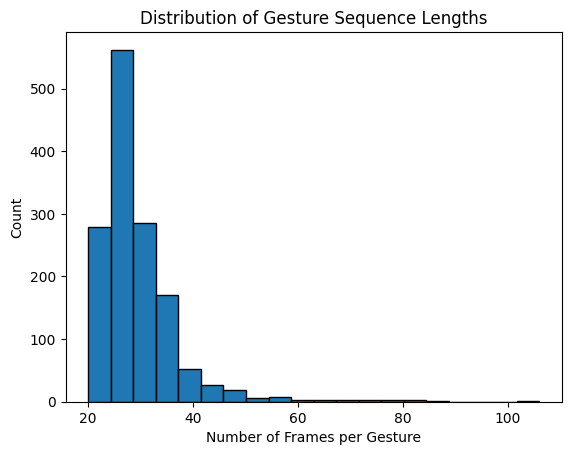

In [5]:
length = []

for pose in poses:

    single_pose = np.load(pose)

    frames = single_pose.shape[0]
    length.append(frames)

plt.hist(length, bins = 20, edgecolor = 'black')
plt.xlabel('Number of Frames per Gesture')
plt.ylabel('Count')
plt.title('Distribution of Gesture Sequence Lengths')

Most frames fall between 20-35, so it does not make so much sense to pad all those frames
up to over 100 just to accommodate the few occurrences of long durations. So, in this case,
I will interpolate frames up to 40, and take interval frames to reduce longer durations down
to 40.

In [9]:
def resample_frames(pose, target_frames=40):
    """
    Resample a pose sequence to exactly target_frames.
    pose: np.array of shape (frames, ...), can be 2D, 3D, etc.
    Returns: np.array of shape (target_frames, ...)
    """
    original_frames = pose.shape[0]
    if original_frames == target_frames:
        return pose

    # Create interpolation function along the frame axis
    interp_func = interp1d(
        np.arange(original_frames),
        pose,
        axis = 0,
        kind = 'linear'
    )

    # Generate target indices
    target_idx = np.linspace(0, original_frames - 1, target_frames)

    # Interpolate
    resampled = interp_func(target_idx)
    return resampled

In [10]:
resampled_poses = []

for pose in poses:

    single_pose = np.load(pose)

    resampled_poses.append(resample_frames(single_pose))

Text(0.5, 1.0, 'Distribution of Resampled Gesture Sequence Lengths')

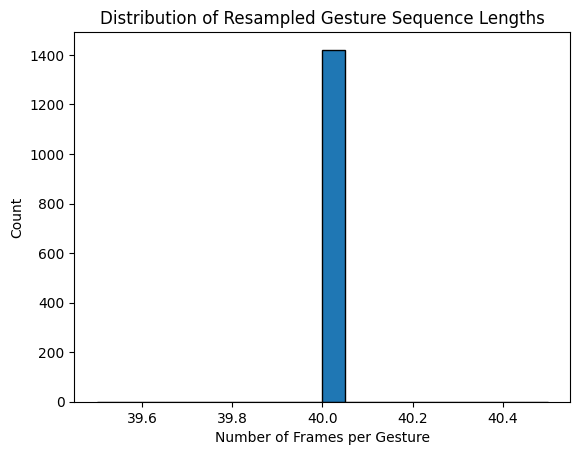

In [12]:
length = []

for pose in resampled_poses:

    frames = pose.shape[0]
    length.append(frames)

plt.hist(length, bins = 20, edgecolor = 'black')
plt.xlabel('Number of Frames per Gesture')
plt.ylabel('Count')
plt.title('Distribution of Resampled Gesture Sequence Lengths')

In [ ]:
def preprocess_hands(sequence: np.ndarray, max_len: int = 40) -> torch.Tensor:
    """
    Preprocess MediaPipe Holistic landmarks: extract hands, normalize, return tensor.
    
    Args:
        sequence (np.ndarray): (frames, 75, 3) from MediaPipe Holistic
        max_len (int): fixed length for padding
    
    Returns:
        torch.Tensor: (max_len, 126) both hands flattened
    """
    frames, landmarks, coords = sequence.shape
    assert landmarks >= 75, "Expected at least 75 landmarks from Holistic"
    
    # Extract hands
    left_hand = sequence[:, 33:54, :]   # (frames, 21, 3)
    right_hand = sequence[:, 54:75, :]  # (frames, 21, 3)
    
    def normalize(hand):
        wrist = hand[:, 0, :]                  # (frames, 3)
        hand = hand - wrist[:, None, :]        # translation
        
        ref_vec = hand[:, 9, :] - hand[:, 0, :]  # wrist → middle MCP
        ref_dist = np.linalg.norm(ref_vec, axis = 1, keepdims = True)
        ref_dist[ref_dist == 0] = 1e-6
        hand = hand / ref_dist[:, None, None]
        return hand
    
    left_hand = normalize(left_hand)
    right_hand = normalize(right_hand)
    
    both = np.concatenate([left_hand, right_hand], axis = 1)  # (frames, 42, 3)
    both = both.reshape(frames, -1)                         # (frames, 126)
    
    # Pad/truncate
    if frames >= max_len:
        both = both[:max_len]
    else:
        pad = np.zeros((max_len - frames, both.shape[1]))
        both = np.vstack([both, pad])
    
    return torch.tensor(both, dtype = torch.float32)

In [21]:
list_of_poses = []

for pose in poses:

    single_pose = np.load(pose)

    list_of_poses.append(preprocess_hands(single_pose, max_len = 40))

list_of_poses[0].shape

os.makedirs('../data/processed', exist_ok = True)

torch.save(list_of_poses, '../data/processed/tensor_list.pt')
